# How to run a Python function on a remote computer

## Introduction
`PythonJob` node is a built-in node, which allow user to run Python function on a remote computer.


Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.

We set `run_remotely` to `True` when adding the node. This will tell the engine that the job is a `Pythonjob` node and should be run on a remote computer.


In [2]:
from aiida_workgraph import node, WorkGraph

# define add node
@node()
def add(x, y):
    return x + y

# define multiply node
@node()
def multiply(x, y):
    return x*y

wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply", x=wg.nodes["add"].outputs[0], run_remotely=True)

# visualize the workgraph
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

### Submit the workgraph

**Code**: We can set the `computer` to the remote computer where we want to run the job. This will create a code `python3@computer` if not exists. Of course, you can also set the `code` directly if you have already created the code.


**Data**: Users can (and is recoomaneded) use normal Python data as input. The workgraph will transfer the data to AiiDA data (`GeneralData`) using pickle.

**Python Version**: since pickle is used to store and load data, the Python version on the remote computer should match the one used in the localhost. One can use conda to create a virtual environment with the same Python version. Then activate the environment before running the script.

```python
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
    }
}
```


WorkGraph node created, PK: 42758

Result of multiply is uuid: a181e040-8cc4-420d-8034-d59a45f2f882 (pk: 42775) : 20 




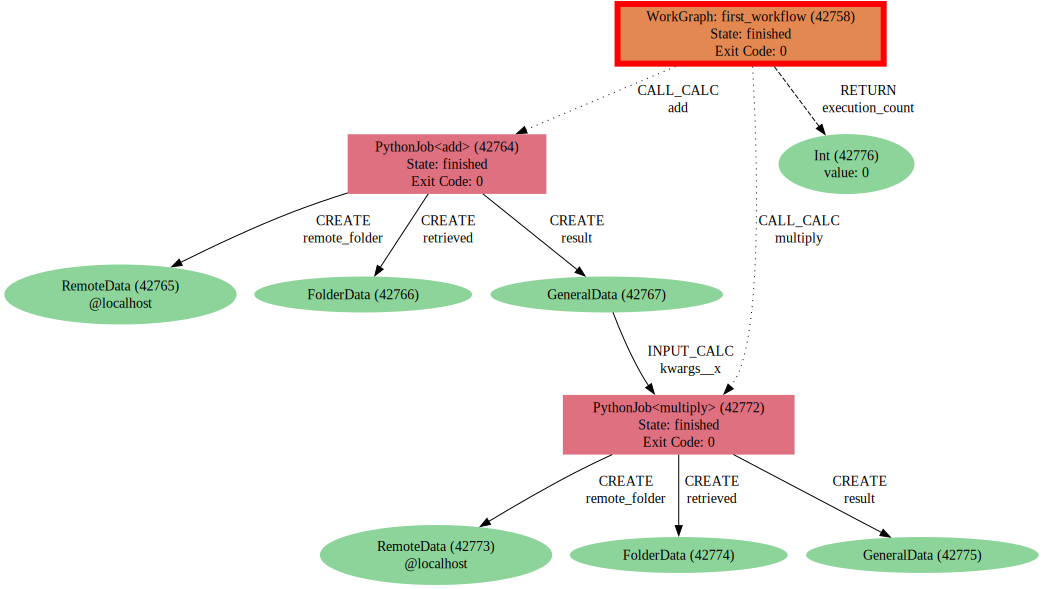

In [3]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Submit the calculation -------------------
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        # 'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
        'custom_scheduler_commands' : '',
    }
}

wg.submit(inputs = {"add": {"x": 2, "y": 3,
                            "computer": "localhost",
                            "metadata": metadata},
                    "multiply": {"y": 4,
                                 "computer": "localhost",
                                 "metadata": metadata}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## Use parent folder
The parent_folder parameter allows a node to access the output files of a parent node. This feature is particularly useful when you want to reuse data generated by a previous computation in subsequent computations. In the following example, the multiply node uses the `result.txt` file created by the add node.


In [4]:
from aiida_workgraph import WorkGraph, node

# define add node
@node()
def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))

# define multiply node
@node()
def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply",
             parent_folder=wg.nodes["add"].outputs["remote_folder"],
             run_remotely=True,
             )

#------------------------- Submit the calculation -------------------
display(wg)
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"x": 3, "y": 4, "computer": "localhost"}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

WorkGraph node created, PK: 42777

Result of multiply is uuid: 041d8038-a9b2-4afe-bdd9-a3285be585f7 (pk: 42795) : 17 




## First Real-world Workflow: atomization energy of molecule

The atomization energy, $\Delta E$, of a molecule can be expressed as:

$$
\Delta E = n_{\text{atom}} \times E_{\text{atom}} - E_{\text{molecule}}
$$

Where:
- $\Delta E$ is the atomization energy of the molecule.
- $n_{\text{atom}}$ is the number of atoms.
- $E_{\text{atom}}$ is the energy of an isolated atom.
- $E_{\text{molecule}}$ is the energy of the molecule.


### Define a node to calculate the energy of the atoms using EMT potential

In [5]:
from aiida_workgraph import node, WorkGraph

@node()
def emt(atoms):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
    energy = atoms.get_potential_energy()
    return energy


@node()
def atomization_energy(mol, energy_molecule, energy_atom):
    energy = energy_atom*len(mol) - energy_molecule
    return energy


### Define a workgraph


In [6]:
wg = WorkGraph("atomization_energy")
pw_atom = wg.nodes.new(emt, name="emt_atom", run_remotely=True)
pw_mol = wg.nodes.new(emt, name="emt_mol", run_remotely=True)
# create the node to calculate the atomization energy
wg.nodes.new("PythonJob", function=atomization_energy, name="atomization_energy",
             energy_atom=pw_atom.outputs["result"],
             energy_molecule=pw_mol.outputs["result"])
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'atomiza…

### Prepare the inputs and submit the workflow

WorkGraph node created, PK: 42797
Energy of a N atom:                  5.100
Energy of an un-relaxed N2 molecule: 0.549
Atomization energy:                  9.651 eV


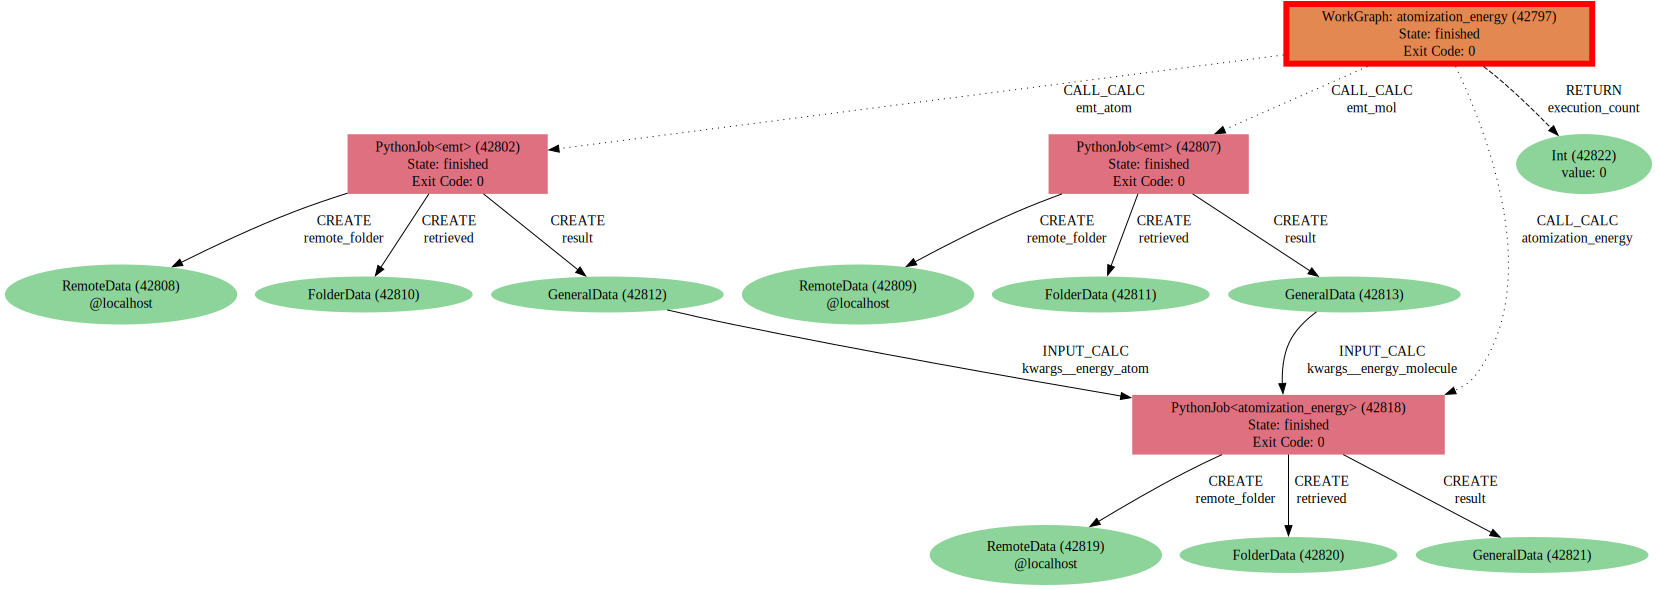

In [7]:
from ase.build import molecule
from ase import Atoms

load_profile()

# create input structure node
n_atom = Atoms("N", pbc=True)
n_atom.center(vacuum=5.0)
n2_molecule = molecule("N2", pbc=True)
n2_molecule.center(vacuum=5.0)


#------------------------- Set the inputs -------------------------
wg.nodes["emt_atom"].set({"atoms": n_atom, "computer": "localhost"})
wg.nodes["emt_mol"].set({"atoms": n2_molecule, "computer": "localhost"})
wg.nodes["atomization_energy"].set({"mol": n2_molecule, "computer": "localhost"})
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=200)
#------------------------- Print the output -------------------------
print('Energy of a N atom:                  {:0.3f}'.format(wg.nodes['emt_atom'].outputs["result"].value.value))
print('Energy of an un-relaxed N2 molecule: {:0.3f}'.format(wg.nodes['emt_mol'].outputs["result"].value.value))
print('Atomization energy:                  {:0.3f} eV'.format(wg.nodes['atomization_energy'].outputs["result"].value.value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)


## Call shell commands in the PythonJob node

We want to calculate `(x+y)*z` in two steps using `echo` and `bc` commands.

Step 1: Calculate (x+y) and store it as result
```
result=$(echo "$x + $y" | bc)
```

Step 2: Multiply result by z and store the final result
```
result=$(echo "$result * $z" | bc)
```

If one wanted to run this workflow in AiiDA, one would have to write plugins for `echo` and `bc` commands, and a WorkChain to handle the workflow. With aiida-workgraph and the `PythonJob` node, this can be run through AiiDA with the following workgraph:

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

WorkGraph node created, PK: 42823

Result of multiply is uuid: 01fd93c9-c0ff-4cf6-8586-a222c2bc8965 (pk: 42840) : 20.0 




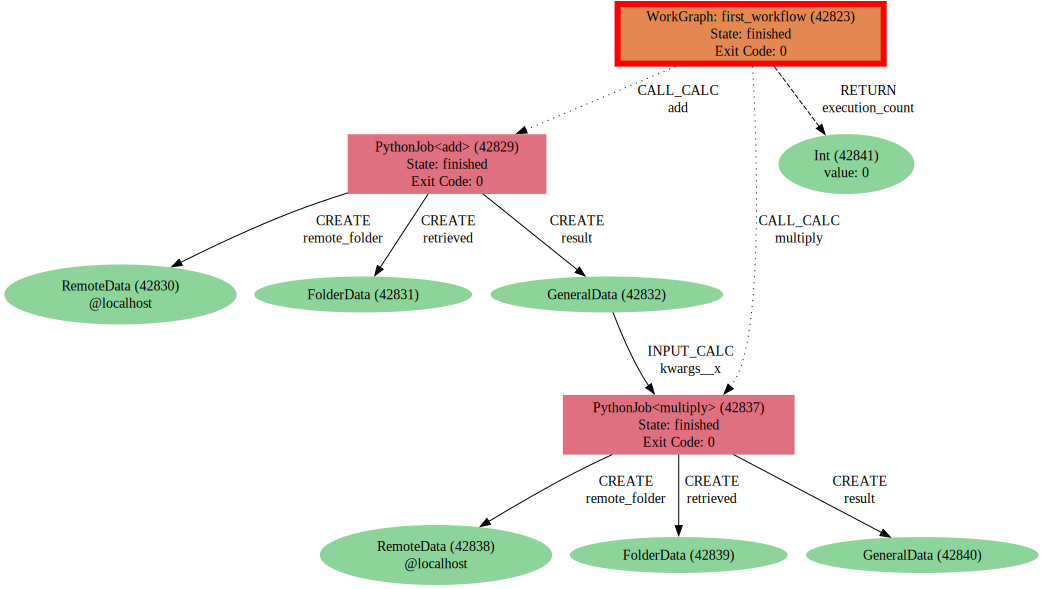

In [8]:
from aiida_workgraph import  node, WorkGraph

@node()
def add(x, y):
    import os
    os.system("echo '{} + {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


@node()
def multiply(x, y):
    import os
    os.system("echo '{} * {}' | bc > result.txt".format(x, y))
    with open("result.txt", "r") as f:
        return float(f.read())


wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply", x=wg.nodes["add"].outputs[0], run_remotely=True)

# visualize the workgraph
display(wg)

#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"y": 4, "computer": "localhost"}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

## What's Next
